In [1]:
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utils import *

In [2]:
directory = '../images/final/'
width = 128
height = 128
channels = 4
image_size = (width, height)
input_shape = (width, height, channels)
batch_size = 32
latent_dim = 100

In [3]:
train_ds, class_names = load_data(directory, batch_size, image_size, GAN=True)

Found 13849 files belonging to 905 classes.


In [4]:
train_ds = prepare(train_ds, shuffle=True, augment=True, GAN=True)

channels = 3
input_shape = (width, height, channels)

In [5]:
plot_n_images(train_ds, 5, class_names, GAN=True)

image shape :  (128, 128, 3)


In [6]:
# define the discriminator model
def define_discriminator(in_shape=input_shape):
    model = tf.keras.Sequential()
    # normal
    model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # downsample to 64x64
    model.add(tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # downsample to 32x32
    model.add(tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # downsample to 16x16
    model.add(tf.keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # downsample to 8x8
    model.add(tf.keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # classifier
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [7]:
# define the standalone generator model
def define_generator(latent_dim):
    model = tf.keras.Sequential()
    # foundation for 8x8 feature maps
    n_nodes = 256 * 8 * 8
    model.add(tf.keras.layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((8, 8, 256)))
    # upsample to 16x16
    model.add(tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # output layer
    model.add(tf.keras.layers.Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [8]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = tf.keras.Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [9]:
# build and compile the discriminator
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)      

In [10]:
# build the generator
generator = define_generator(latent_dim)
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1654784   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      1048832   
 nspose)                                                         
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      1048832   
 ranspose)                                            

In [11]:
# build the gan
gan_model = define_gan(generator, discriminator)
gan_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 128, 128, 3)       4542595   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1124865   
                                                                 
Total params: 5,667,460
Trainable params: 4,542,595
Non-trainable params: 1,124,865
_________________________________________________________________


In [15]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input, verbose=0)
    # create 'fake' class labels (0)
    y = tf.zeros((n_samples, 1))
    return X, y

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = tf.random.normal(shape=(n_samples, latent_dim))
    return x_input

def generate_real_samples(dataset, n_samples):
    X = []
    while len(X) < n_samples:
        dataset.shuffle(100, seed=123)
        for x, _ in dataset.take(5):
            for i in range(len(x)):
                X.append(x[i])
                if len(X) == n_samples:
                    break
            if len(X) == n_samples:
                break
    X = tf.stack(X)
    y = tf.ones((n_samples, 1))
    return X, y

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_e%03d.h5' % (epoch+1)
    g_model.save(filename)

def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, :])
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [20]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64):
    bat_per_epo = int(dataset.cardinality())
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j, batch in enumerate(dataset):
            # get randomly selected 'real' samples
            X_real = batch[0]
            half_batch = int(X_real.shape[0])
            y_real = tf.ones((half_batch, 1))
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = tf.concat([X_real, X_fake], axis=0), tf.concat([y_real, y_fake], axis=0)
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = tf.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
    # save the generator model
    g_model.save('generator_model_final.h5')
    d_model.save('discriminator_model_final.h5')


In [22]:
# train model
train(generator, discriminator, gan_model, train_ds, latent_dim, n_epochs=51)

## ZONE DE TEST

In [23]:
try :
    generator, discriminator = tf.keras.models.load_model('generator_model_64_final.h5'), tf.keras.models.load_model('discriminator_model_64.h5')
except:
    generator, discriminator = tf.keras.models.load_model('generator_model_50_64.h5'), tf.keras.models.load_model('discriminator_model_50_64.h5')

In [24]:
X = generator.predict(generate_latent_points(100, 1), verbose=0)
plot_image(X[0], "image générée", {"real": float(discriminator.predict(X, verbose=0))}, size=64)

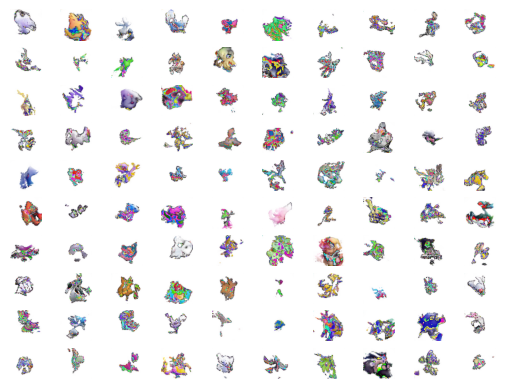

In [25]:
n = 10
x_fake, _ = generate_fake_samples(generator, 100, n * n)
x_fake = (x_fake * 255).astype('uint8')
# plot images
for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(x_fake[i, :, :, :])
# save plot to file
# plt.savefig("generated_plot_GAN_64.png")
plt.show()
plt.close()